In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, accuracy_score, multilabel_confusion_matrix, classification_report
from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel # , BertTokenizer, BertModel
from tqdm import tqdm
from collections import defaultdict
import yaml

# from nltk.stem import WordNetLemmatizer, PorterStemmer
# from nltk.tokenize import word_tokenize

c:\Users\gedas\anaconda3\envs\cybercare\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import model configuration
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# 1. Exploratory data analysis

In [3]:
# Load the data
data = pd.read_parquet('cc_data.parquet').sample(frac=0.4, random_state=12345)  # debug
# data = pd.read_parquet('cc_data.parquet')

# Display basic info
print("INFO:")
data.info()
print("HEAD:\n", data.head())
print("DESCRIBE:\n", data.describe())

# This is for initial data exploration
# We are interested to see if there are null values in the data
# We also want to see how big is the file
# Check for any anomalies in the data, and we notice very low mean values for QB and QF
# This means that the data is imbalanced

INFO:
<class 'pandas.core.frame.DataFrame'>
Index: 6753 entries, 9062 to 4728
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   TITLE                 6753 non-null   object
 1   ABSTRACT              6753 non-null   object
 2   Computer Science      6753 non-null   int64 
 3   Physics               6753 non-null   int64 
 4   Mathematics           6753 non-null   int64 
 5   Statistics            6753 non-null   int64 
 6   Quantitative Biology  6753 non-null   int64 
 7   Quantitative Finance  6753 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 474.8+ KB
HEAD:
                                                    TITLE  \
9062   Connectivity Properties of Factorization Poset...   
11887  InfoVAE: Information Maximizing Variational Au...   
6931   The origin and early evolution of life in chem...   
8690   Monadic Second Order Logic with Measure and Ca...   
13788  Optical reconfiguration 

Number of papers per subject:
Computer Science        2822
Physics                 1886
Mathematics             1836
Statistics              1671
Quantitative Biology     186
Quantitative Finance      68
dtype: int64


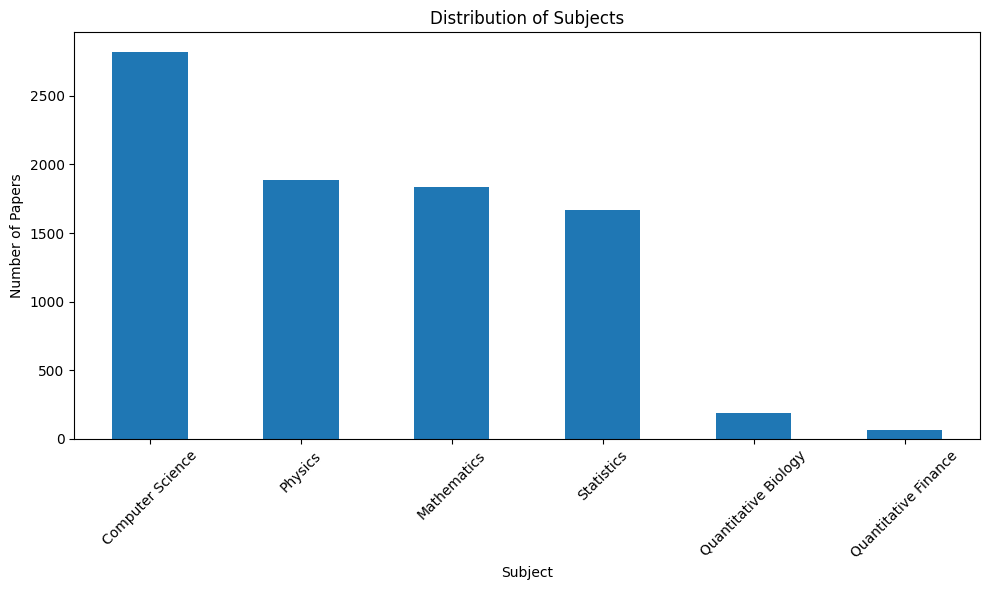

Avg. title length: 73.27572930549385
Avg. abstract length: 1006.9142603287428


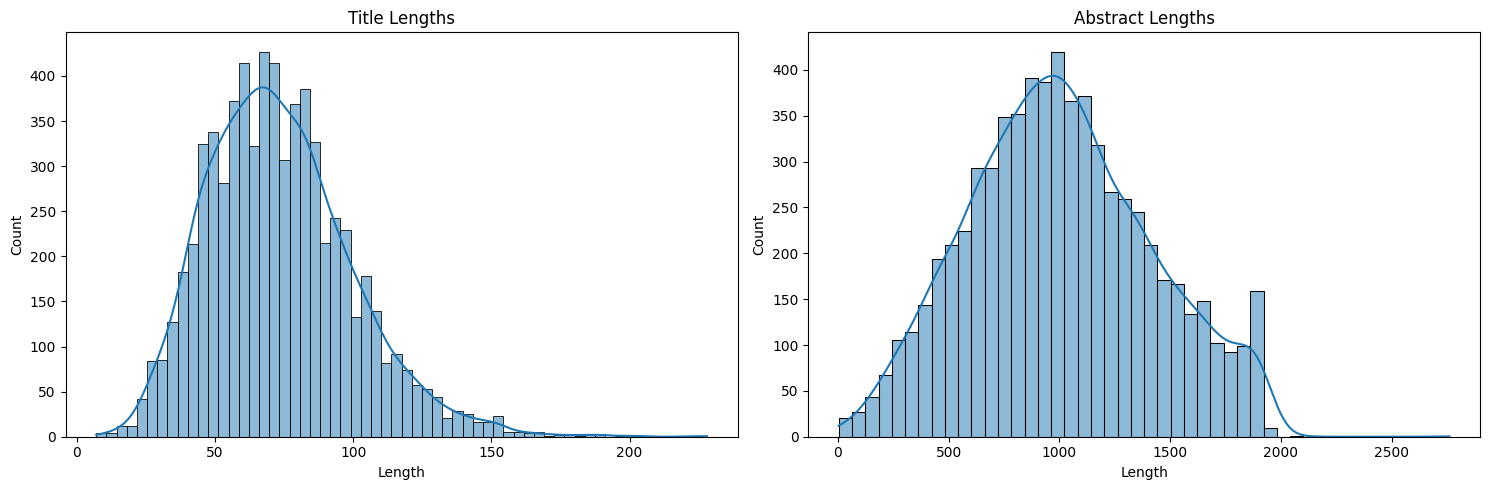

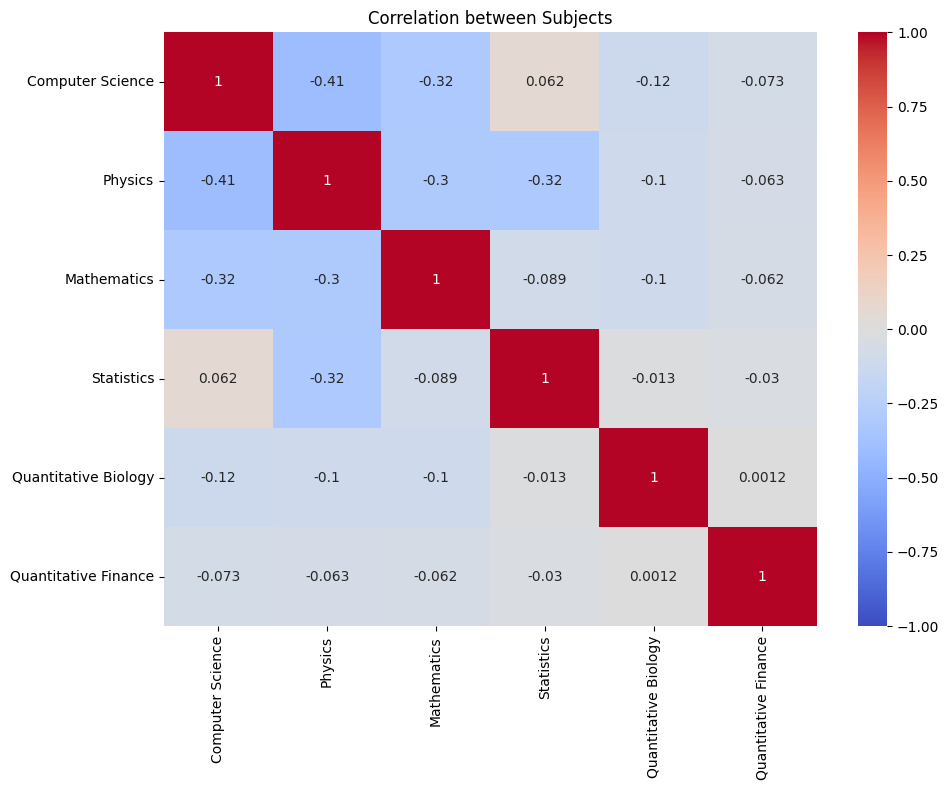

In [4]:
# Let's visualize numbers for a better picture 
subject_names = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']

# How many papers for each subject
subject_counts = data[subject_names].sum()
print("Number of papers per subject:")
print(subject_counts)

plt.figure(figsize=(10, 6))
subject_counts.plot(kind='bar')
plt.title('Distribution of Subjects')
plt.xlabel('Subject')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# In fact, these graphs show that the data is imbalanced, especially QB and QF

# Now let's see the distribution of lenghts of titles and abstracts
data['title_length'] = data['TITLE'].str.len()
data['abstract_length'] = data['ABSTRACT'].str.len()

print("Avg. title length:", data['title_length'].mean())
print("Avg. abstract length:", data['abstract_length'].mean())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data['title_length'], kde=True, ax=ax1)
ax1.set_title('Title Lengths')
ax1.set_xlabel('Length')
sns.histplot(data['abstract_length'], kde=True, ax=ax2)
ax2.set_title('Abstract Lengths')
ax2.set_xlabel('Length')
plt.tight_layout()
plt.show()

# We can see that there are some outliers in the data, short abstracts. What could be the reason?
# We will investigate this further

# We should also investigate for any correlations, this could help us in the future
# It is always a good idea to know as much about the data as possible
subject_correlation = data[subject_names].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(subject_correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation between Subjects')
plt.tight_layout()
plt.show()

# We see that CS and Physics have a correlation of -0.41
# This means that if a paper is about CS, it is less likely to be about Physics
# Nothing too interesting here, but it is good to know

In [5]:
# We come back to the question: Why do we have short abstracts?

short_abstracts = data[data['ABSTRACT'].str.len() < 50]
print(f"\nNumber of short abstracts: {len(short_abstracts)}")
print("\nFirst 10 short abstracts:")
for i, (index, row) in enumerate(short_abstracts.iterrows()):
    if i >= 10:
        break
    print(f"\nAbstract {i+1}:")
    print(f"Title: {row['TITLE']}")
    print(f"Abstract: {row['ABSTRACT']}")
    print(f"Length: {len(row['ABSTRACT'])}")
    print(f"Subjects: {', '.join([subj for subj in row.index[2:8] if row[subj] == 1])}")

# We find that the abstracts are short because the subject is obvious from the title.
# Abstract 3 is an example of a short abstract that is garbage data (we avoid 'garbage in, gargabe out' at all costs)
# So, we will remove all entries where the combined length of the title and abstract is less than some parameter
# because that is too hard to interpret, even for a human


Number of short abstracts: 20

First 10 short abstracts:

Abstract 1:
Title: Solution to the relaxation problem for a gas with a distribution function dependent on the velocity modulus
Abstract: The...
Length: 6
Subjects: Physics

Abstract 2:
Title: Understanding the Impact of Early Citers on Long-Term Scientific Impact
Abstract: This...
Length: 7
Subjects: Computer Science

Abstract 3:
Title: Measured Multiseries and Integration
Abstract: A...
Length: 4
Subjects: Computer Science

Abstract 4:
Title: The distribution of symmetry of a naturally reductive nilpotent Lie group
Abstract: We...
Length: 5
Subjects: Mathematics

Abstract 5:
Title: A Survey of Runtime Monitoring Instrumentation Techniques
Abstract: Runtime...
Length: 10
Subjects: Computer Science

Abstract 6:
Title: Giant ripples on comet 67P/Churyumov-Gerasimenko sculpted by sunset thermal wind
Abstract: Explaining...
Length: 13
Subjects: Physics

Abstract 7:
Title: Fundamental Limitations of Cavity-assisted Atom Interferomet

In [6]:
# I think it's a good idea to see the most popular words
# This could give us some insight into the data

# Word Frequency Analysis
def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

for subject in subject_names:
    print(f"\nTop 10 words in {subject}:")
    top_words = get_top_n_words(data[data[subject] == 1]['ABSTRACT'], n=10)
    print(top_words)
print('\n')

# We can see that the most popular words are 'data', 'model'.
# If we were to use other models than BERT, I would consider removing these words as they are not very informative

# Viceversa, we should also explore for exclusive words, get more insight into the data
def get_unique_words(data, subject_names, column='ABSTRACT'):
    subject_words = defaultdict(set)
    
    # Get words for each subject
    for subject in subject_names:
        vec = CountVectorizer(stop_words='english').fit(data[data[subject] == 1][column])
        subject_words[subject] = set(vec.get_feature_names_out())
    
    # Find unique words for each subject
    unique_words = {}
    for subject in subject_names:
        other_subjects = set(subject_names) - {subject}
        words_in_other_subjects = set.union(*[subject_words[s] for s in other_subjects])
        unique_words[subject] = subject_words[subject] - words_in_other_subjects
    
    return unique_words

unique_words_per_subject = get_unique_words(data, subject_names)

for subject, words in unique_words_per_subject.items():
    print(f"\nUnique words in {subject}:")
    print(sorted(list(words))[:20])
print('\n')

# We can see that there are many unique numbers in the data, which are not very informative
# It is only useful if the number has characters after it, like Hz, kda, mb, etc.
# I will remove numbers from the data and check again
def remove_standalone_numbers(text):
    return re.sub(r'\b\d+(?:\.\d+)?(?:[eE][+-]?\d+)?\b(?!\w)', '', text)

data['NONUMBER_ABSTRACT'] = data['ABSTRACT'].apply(remove_standalone_numbers)
unique_words_per_subject = get_unique_words(data, subject_names, 'NONUMBER_ABSTRACT')

for subject, words in unique_words_per_subject.items():
    print(f"\nUnique words in {subject}:")
    print(sorted(list(words))[:20])

# Everything seems better now
# For some optimizations it's a viable strategy to replace numbers with a special token, but I will not do that here


Top 10 words in Computer Science:
[('data', 2009), ('model', 1687), ('based', 1668), ('learning', 1523), ('problem', 1364), ('paper', 1356), ('network', 1280), ('algorithm', 1241), ('time', 1210), ('using', 1201)]

Top 10 words in Physics:
[('model', 880), ('using', 686), ('field', 684), ('results', 662), ('time', 639), ('data', 633), ('energy', 605), ('high', 605), ('based', 588), ('phase', 548)]

Top 10 words in Mathematics:
[('paper', 688), ('problem', 642), ('results', 528), ('prove', 484), ('model', 475), ('study', 459), ('mathbb', 459), ('function', 415), ('method', 414), ('space', 412)]

Top 10 words in Statistics:
[('data', 1757), ('learning', 1310), ('model', 1226), ('based', 908), ('models', 866), ('method', 820), ('methods', 735), ('using', 708), ('paper', 702), ('problem', 690)]

Top 10 words in Quantitative Biology:
[('data', 168), ('model', 150), ('networks', 118), ('network', 99), ('models', 92), ('based', 85), ('results', 84), ('different', 83), ('brain', 79), ('method

# 2. Data preprocessing

In [7]:
# Settings to remove warnings, new pandas version unhappy for some reason
pd.options.mode.copy_on_write = True

class ScientificPaperDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        # self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        # SciBERT is a BERT model trained on scientific text, so we will use it to better fit our needs
        self.tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
        # BERT's maximum sequence length 512, but for performance reasons we will use 64
        self.max_length = config['data']['max_length']  

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(labels)
        }

def preprocess_data(data, is_test=False, test_size=0.2, random_state=12345):
    # We combine TITLE + ABSTRACT
    data['text'] = data['TITLE'] + ' ' + data['ABSTRACT']

    # Remove entries with very short text
    data = data[data['text'].str.len() > 35]

    # Common text preprocessing
    data['text'] = data['text'].str.lower()
    data['text'] = data['text'].apply(remove_standalone_numbers)
    data['text'] = data['text'].str.replace('[^a-zA-Z\s]', '', regex=True)
    data['text'] = data['text'].str.replace('\s+', ' ', regex=True).str.strip()

    if is_test:
        # For test data, we don't split or create labels
        dataset = ScientificPaperDataset(data['text'].tolist(), [[0]*6]*len(data))
        return dataset, data['text'], data['ABSTRACT']
    else:
        # Prep labels
        train_data, val_data = train_test_split(data, test_size=test_size, random_state=random_state, stratify=data[subject_names].sum(axis=1))

        # Datasets
        train_dataset = ScientificPaperDataset(train_data['text'].tolist(), train_data[subject_names].values.tolist())
        val_dataset = ScientificPaperDataset(val_data['text'].tolist(), val_data[subject_names].values.tolist())

        return train_dataset, val_dataset, data['text']

def create_data_loaders(train_dataset, val_dataset, batch_size=32):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    return train_loader, val_loader

train_dataset, val_dataset, processed_texts = preprocess_data(data, test_size=config['data']['test_size'])
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset, batch_size=config['training']['batch_size'])

# Let's see how the data looks like after preprocessing
print(processed_texts.head(10).to_string())

# Looking good, let's move on

9062     connectivity properties of factorization poset...
11887    infovae information maximizing variational aut...
6931     the origin and early evolution of life in chem...
8690     monadic second order logic with measure and ca...
13788    optical reconfiguration and polarization contr...
10364    providing effective realtime feedback in simul...
15301    moments and cumulants of the twostage mannwhit...
16343    multivariate central limit theorems for radema...
5740     local and global boundary rigidity and the geo...
13748    on training recurrent networks with truncated ...


# 3. Model, Training

In [8]:
# Suppress annoying warnings...
# "A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning." 
# "A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning."
from transformers import logging
logging.set_verbosity_error()

class BERTClassifier(nn.Module):
    def __init__(self, num_labels):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(config['model']['pretrained_model'])
        self.dropout = nn.Dropout(0.1) # default dropout
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)  

        # Could also consider different classifier implementations, but this is the simplest one

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        # outputs.last_hidden_state[:, 0, :] # Could be better than pooler_output
        logits = self.classifier(pooled_output)
        return logits

def compute_class_weights(labels, device):
    # Class imbalance correction
    # It should be sufficient to use the inverse of the class frequencies
    labels = np.array(labels)
    class_counts = labels.sum(axis=0)
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum() * len(class_weights)
    return torch.FloatTensor(class_weights).to(device)

def train_model(model, train_loader, num_epochs, device, criterion, lr=2e-5, max_grad_norm=1.0):
    # AdamW optimizer is default 
    optimizer = AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    
    # Variables to keep track of stats
    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []
    val_accuracies = []

    # Main training loop
    for epoch in range(num_epochs):
        model.train()

        # Again, more variables to keep track of epoch stats
        train_loss = 0
        train_preds = []
        train_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Standard training loop
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()

            # This is for stats
            preds = torch.sigmoid(outputs).cpu().detach().numpy()
            train_preds.extend(preds)
            train_labels.extend(labels.cpu().numpy())
        
        # Save all the statistics
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        train_f1 = f1_score((np.array(train_labels) > 0.5).astype(int), 
                            (np.array(train_preds) > 0.5).astype(int), 
                            average='micro')
        train_f1_scores.append(train_f1)

        
        val_loss, val_f1, val_acc = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_f1_scores.append(val_f1)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Val Accuracy: {val_acc:.4f}")

    return model, train_losses, val_losses, train_f1_scores, val_f1_scores, val_accuracies

def evaluate_model(model, data_loader, criterion, device):
    # This is standard implementation of evaluation
    model.eval()

    # Stats variables
    val_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Get predictions
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # This is for stats
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate final stats
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    val_loss /= len(data_loader)
    f1 = f1_score(all_labels, (all_preds > 0.5).astype(int), average='micro')
    accuracy = accuracy_score(all_labels, (all_preds > 0.5).astype(int))
    
    return val_loss, f1, accuracy

def predict(model, data_loader, device):
    # For predicting validation data
    model.eval()

    # Stats variables
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Predicting"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            
            # Get predictions
            outputs = model(input_ids, attention_mask)
            preds = torch.sigmoid(outputs).cpu().numpy()

            # This is for stats
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

print(f"Using: {device}")
print("numpy: " + np.__version__) # doesn't work with 2.0.1 numpy

num_labels = config['model']['num_labels'] # CS, Physics, Math, Stats, QB, QF
model = BERTClassifier(num_labels).to(device)

class_weights = compute_class_weights(train_dataset.labels, device)
# We use BCEWithLogitsLoss because it combines sigmoid and binary cross entropy loss
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))
num_epochs = config['training']['num_epochs']

# Train and save the model
trained_model, train_losses, val_losses, train_f1_scores, val_f1_scores, val_accuracies = train_model(model, train_loader, num_epochs, device, criterion, lr=float(config['training']['learning_rate']))
torch.save(trained_model.state_dict(), config['model']['save_path'])

Using: cuda
numpy: 1.24.3


Epoch 1/3:   0%|          | 0/338 [00:00<?, ?it/s]c:\Users\gedas\anaconda3\envs\cybercare\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Epoch 1/3: 100%|██████████| 338/338 [01:08<00:00,  4.90it/s]


Epoch 1/3
Train Loss: 0.1220, Train F1: 0.3768
Val Loss: 0.0804, Val F1: 0.6119, Val Accuracy: 0.4952


Epoch 2/3: 100%|██████████| 338/338 [01:13<00:00,  4.59it/s]


Epoch 2/3
Train Loss: 0.0738, Train F1: 0.6658
Val Loss: 0.0760, Val F1: 0.6593, Val Accuracy: 0.5056


Epoch 3/3: 100%|██████████| 338/338 [01:09<00:00,  4.88it/s]


Epoch 3/3
Train Loss: 0.0570, Train F1: 0.7472
Val Loss: 0.0750, Val F1: 0.7315, Val Accuracy: 0.5899


# 4. Evaluation

Validation Loss: 0.0743
Validation F1 Score: 0.7214
Validation Accuracy: 0.5744


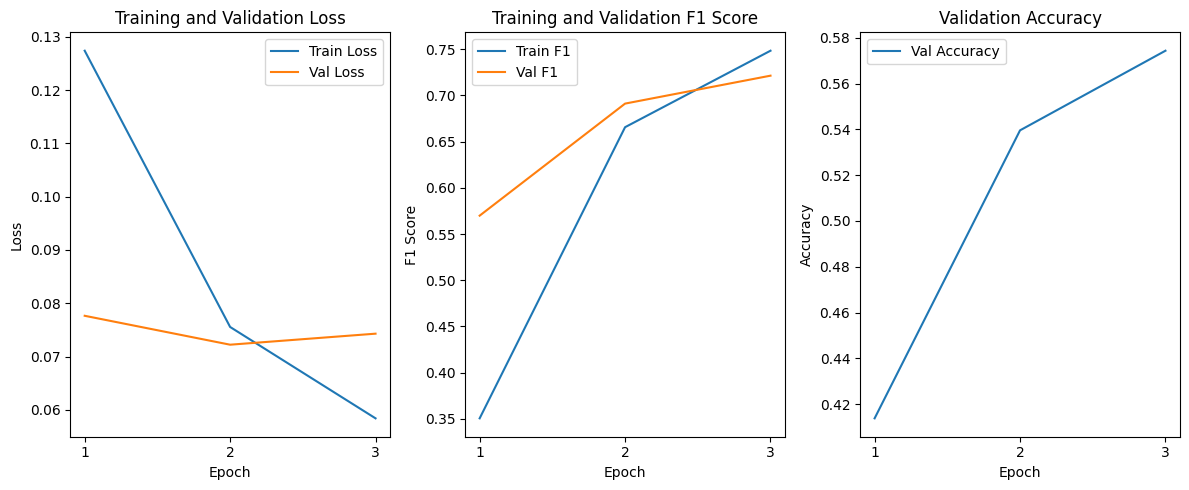

Predicting: 100%|██████████| 85/85 [00:05<00:00, 14.63it/s]


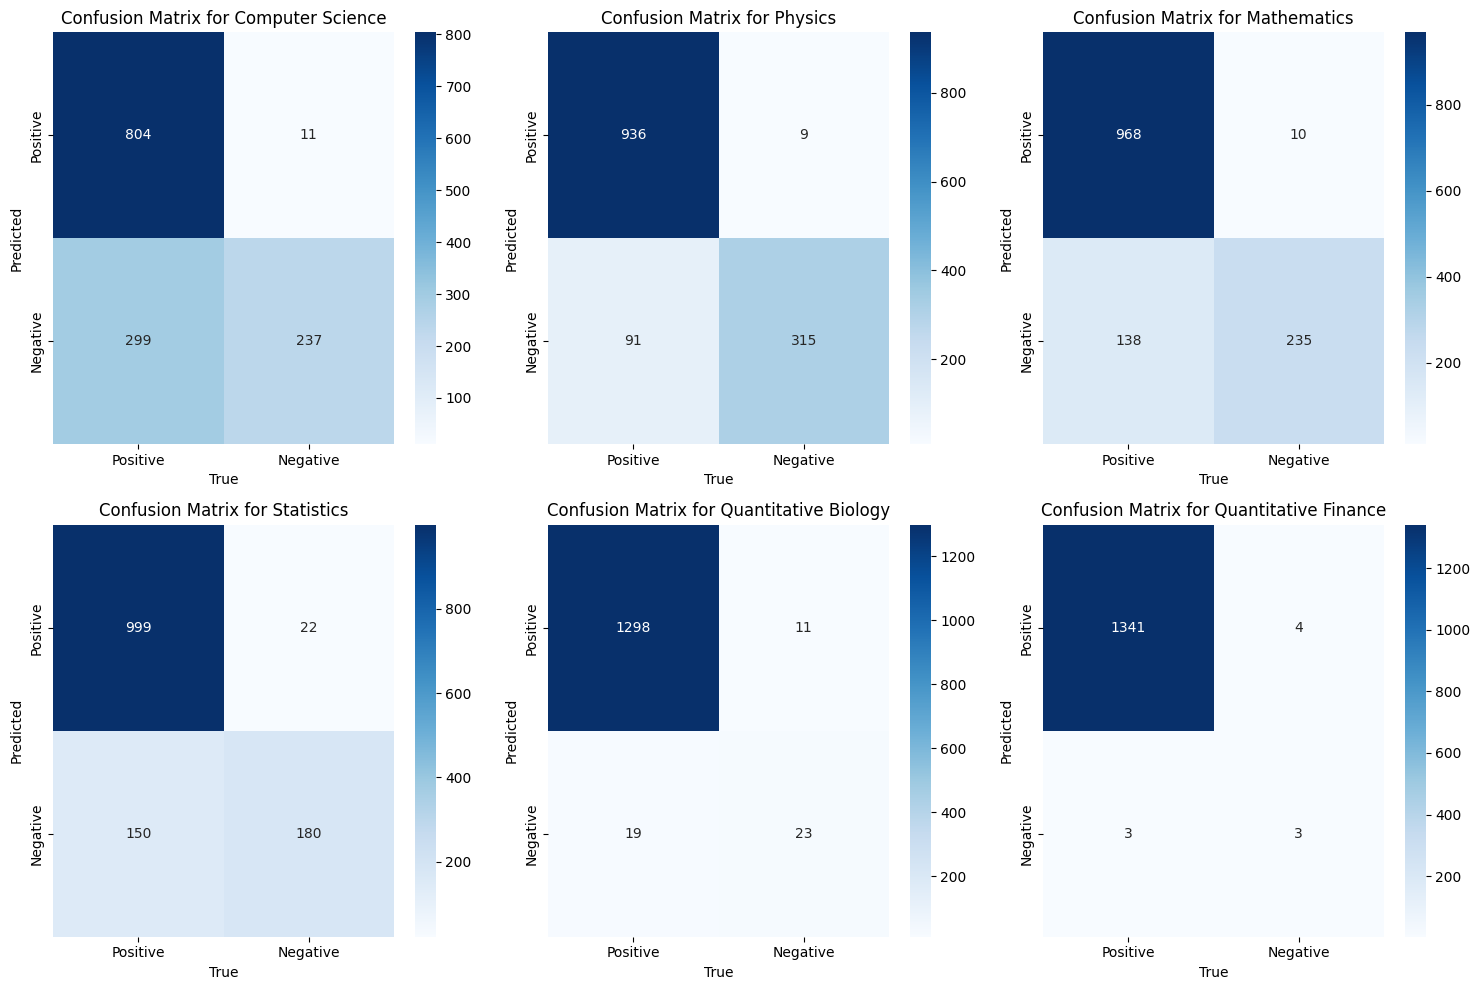


Classification Report:
                      precision    recall  f1-score   support

    Computer Science       0.96      0.44      0.60       536
             Physics       0.97      0.78      0.86       406
         Mathematics       0.96      0.63      0.76       373
          Statistics       0.89      0.55      0.68       330
Quantitative Biology       0.68      0.55      0.61        42
Quantitative Finance       0.43      0.50      0.46         6

           micro avg       0.94      0.59      0.72      1693
           macro avg       0.81      0.57      0.66      1693
        weighted avg       0.94      0.59      0.71      1693
         samples avg       0.73      0.65      0.67      1693



c:\Users\gedas\anaconda3\envs\cybercare\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gedas\anaconda3\envs\cybercare\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gedas\anaconda3\envs\cybercare\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resul

In [ ]:
# I will show the standard plotting and statistics
# But they are not worth discussing too much because we are making a model that is not very good from the beginning
# It is not good due to performance reasons (it is not my priority), I wanted to show the ML piepline

def plot_training_progress(train_losses, val_losses, train_f1_scores, val_f1_scores, val_accuracies):
    plt.figure(figsize=(12, 5))
    
    epochs = range(1, len(train_losses) + 1)

    # Plot for Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(epochs)
    
    # Plot for F1 Score
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_f1_scores, label='Train F1')
    plt.plot(epochs, val_f1_scores, label='Val F1')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.xticks(epochs)
    
    # Plot for Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(epochs)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = multilabel_confusion_matrix(y_true, y_pred)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, (ax, matrix, label) in enumerate(zip(axes, cm, labels)):
        # Rearrange matrix to standard format (for me)
        matrix = matrix[::-1, ::-1]  # Flip
        matrix = np.array([[matrix[1,1], matrix[1,0]],  # TP, FP
                           [matrix[0,1], matrix[0,0]]])  # FN, TN

        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'Confusion Matrix for {label}')
        ax.set_ylabel('Predicted')
        ax.set_xlabel('True')
        ax.xaxis.set_ticklabels(['Positive', 'Negative'])
        ax.yaxis.set_ticklabels(['Positive', 'Negative'])
    
    plt.tight_layout()
    plt.show()

# Plotting

val_loss, val_f1, val_accuracy = evaluate_model(trained_model, val_loader, criterion, device)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
plot_training_progress(train_losses, val_losses, train_f1_scores, val_f1_scores, val_accuracies)

# Loss is going down, F1 score is going up, Accuracy is going up
# This is expected because the model is learning
# If we had more epochs, we would see better results (hopefully)

val_preds, val_true = predict(trained_model, val_loader, device)
val_preds_binary = (val_preds > 0.5).astype(int)
val_true_binary = (val_true > 0.5).astype(int)
plot_confusion_matrix(val_true_binary, val_preds_binary, subject_names)

print("\nClassification Report:")
print(classification_report(val_true_binary, val_preds_binary, target_names=subject_names))

# CM shows struggle to learn the patterns for the minority class because of low recall
# Expected poor results because Dataset max_length=64, should be 512
# Low epochs contribute to poor results
# No hyperparameter fine-tuning contribue to poor results


# 5. Predict test data

In [ ]:
# Load and preprocess the test data
test_data = pd.read_parquet('cc_test.parquet')
test_dataset, processed_texts, abstracts = preprocess_data(data=test_data, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=config['training']['batch_size'])

# Load the trained model
model = BERTClassifier(num_labels=config['model']['num_labels']).to(device)
model.load_state_dict(torch.load(config['model']['save_path']))
model.eval()

# Predict
all_preds = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(input_ids, attention_mask)
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds.extend(preds)
predictions_df = pd.DataFrame(all_preds, columns=subject_names)

# I did not see any instructions about the format of the output file
# So, we will create an ID column, ABSTRACT column for easier identification
# And, a list of predicted subjects column (threshold-based) and top 2 predicted subjects column
# Threshold-based because these are high confidence predictions, top 2 because it is useful to know the top 2 subjects (sometimes the model predicts empty list)
# And also have 6 columns with predicted subjects probabilities
predictions_df['ID'] = range(len(predictions_df))
predictions_df['Abstract'] = abstracts

predictions_df['Subjects_Threshold'] = predictions_df[subject_names].apply(
    lambda row: [subject for subject, value in row.items() if value > 0.5], axis=1
)
predictions_df['Subjects_Top2'] = predictions_df[subject_names].apply(
    lambda row: [subject for subject, value in sorted(row.items(), key=lambda x: x[1], reverse=True)[:2]], axis=1
)

predictions_df = predictions_df[['ID', 'Abstract', 'Subjects_Threshold', 'Subjects_Top2'] + subject_names]

# Export
predictions_df.to_parquet('predictions.parquet')
print("Predictions have been saved to predictions.parquet")

Predicting: 100%|██████████| 263/263 [00:18<00:00, 14.15it/s]


Predictions have been saved to predictions.parquet
